## Import Libraries

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
import albumentations as A
from torch.utils.data import DataLoader, random_split

c:\Users\albia\anaconda3\envs\pytorch_env\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Import Env File

In [3]:
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('DATASET_PATH')
models_path = os.getenv('MODELS_PATH')

## Device Configuration

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Hyperparameters

In [5]:
num_classes = 2  
batch_size = 16
test_split_ratio = 0.2
image_size = (224, 224)

## Data Preprocessing

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# Augmentasi (Albumentations)
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.Affine(scale=(0.95, 1.05), translate_percent=(0.05, 0.05), rotate=15, p=0.4)
])

In [8]:
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np

class AugmentTransformImageFolder(ImageFolder):
    def __init__(self, root, augment=None, transform=None):
        super().__init__(root)
        self.augment = augment
        self.transform = transform

    def __getitem__(self, index):
        path, target = self.samples[index]
        image = self.loader(path)  # PIL image

        # Convert PIL to NumPy if using Albumentations
        if self.augment:
            image_np = np.array(image)
            image_np = self.augment(image=image_np)['image']
            image = Image.fromarray(image_np)

        if self.transform:
            image = self.transform(image)

        return image, target


## Data Loaders

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

# Load dataset dengan class custom
full_dataset = AugmentTransformImageFolder(root=datasets_path, augment=augment, transform=transform)

# Ambil semua label dari dataset
targets = full_dataset.targets
indices = list(range(len(full_dataset)))

# Stratified split
train_indices, test_indices = train_test_split(
    indices, test_size=test_split_ratio, stratify=targets, random_state=42
)

# Subset berdasarkan indeks
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
from collections import Counter

print("Distribusi kelas (train):", Counter([full_dataset.targets[i] for i in train_indices]))
print("Distribusi kelas (test):", Counter([full_dataset.targets[i] for i in test_indices]))

Distribusi kelas (train): Counter({0: 80, 1: 77})
Distribusi kelas (test): Counter({0: 20, 1: 20})


In [11]:
# Cetak semua label kelas di dalam dataset
print("Daftar kelas dalam dataset:")
print(full_dataset.classes)

Daftar kelas dalam dataset:
['jogja', 'pekalongan']


## load Pre-Trained Model

In [12]:
class EfficientNetCustom(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetCustom, self).__init__()

        # Load EfficientNetB0 pretrained backbone
        self.base_model = models.efficientnet_b0(pretrained=True)

        # Ambil semua layer kecuali classifier
        self.features = self.base_model.features
        self.avgpool = self.base_model.avgpool
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.base_model.classifier[1].in_features, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)      # flatten semua kecuali batch dim
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Train The Model

In [13]:
# Loss and optimizer
model = EfficientNetCustom(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Inisialisasi early stopping
best_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 5
num_epochs = 60

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Hitung rata-rata loss untuk epoch ini
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Logika Early Stopping
    if epoch_loss < best_loss - 1e-4:
        best_loss = epoch_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print(f"⛔ Early stopping triggered at epoch {epoch+1}")
        break

c:\Users\albia\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\albia\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/60], Loss: 0.7027
Epoch [2/60], Loss: 0.6973
Epoch [3/60], Loss: 0.6665
Epoch [4/60], Loss: 0.6335
Epoch [5/60], Loss: 0.5994
Epoch [6/60], Loss: 0.5750
Epoch [7/60], Loss: 0.5434
Epoch [8/60], Loss: 0.5351
Epoch [9/60], Loss: 0.5032
Epoch [10/60], Loss: 0.4807
Epoch [11/60], Loss: 0.4524
Epoch [12/60], Loss: 0.4143
Epoch [13/60], Loss: 0.4127
Epoch [14/60], Loss: 0.3730
Epoch [15/60], Loss: 0.3333
Epoch [16/60], Loss: 0.2956
Epoch [17/60], Loss: 0.2927
Epoch [18/60], Loss: 0.2747
Epoch [19/60], Loss: 0.2180
Epoch [20/60], Loss: 0.2107
Epoch [21/60], Loss: 0.1814
Epoch [22/60], Loss: 0.1981
Epoch [23/60], Loss: 0.1489
Epoch [24/60], Loss: 0.1456
Epoch [25/60], Loss: 0.1121
Epoch [26/60], Loss: 0.1256
Epoch [27/60], Loss: 0.0834
Epoch [28/60], Loss: 0.0822
Epoch [29/60], Loss: 0.0889
Epoch [30/60], Loss: 0.0882
Epoch [31/60], Loss: 0.0654
Epoch [32/60], Loss: 0.0658
Epoch [33/60], Loss: 0.0748
Epoch [34/60], Loss: 0.0851
Epoch [35/60], Loss: 0.0596
Epoch [36/60], Loss: 0.0553
E

## Evaluation

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluasi klasifikasi
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.6957    0.8000    0.7442        20
           1     0.7647    0.6500    0.7027        20

    accuracy                         0.7250        40
   macro avg     0.7302    0.7250    0.7234        40
weighted avg     0.7302    0.7250    0.7234        40



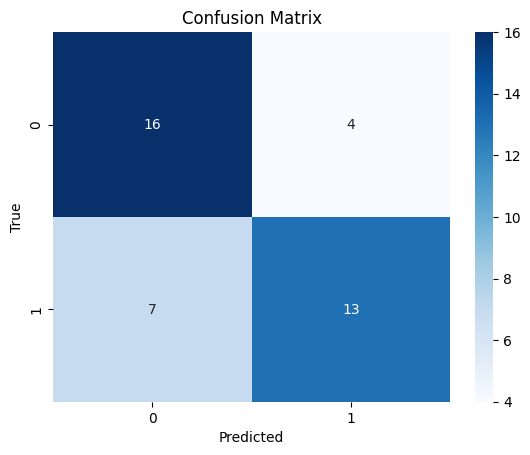

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Save The Model

In [16]:
torch.save(model.state_dict(), models_path+'/CNN.pth')